In [1]:
import numpy as np
from WLM import *
from f_chain import kappa_eff
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('none')
from scipy.ndimage import gaussian_filter

<Figure size 1152x1152 with 0 Axes>

In [2]:
def grid_coords(grid):
    if grid=='SC':
        # 6 orientations following the arrangement of standard dice
        # 1/6 for +x/-x; 2/5 for +y/-y; 3/4 for +z/-z
        r_n = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,-1],[0,-1,0],[-1,0,0]])
        r_opp = np.array([5,4,3,2,1,0])
    
    if grid=='RB':
        # rhombic dodecahedron
        r_n = np.array([[0,1,1],[0,-1,-1],[0,1,-1],[0,-1,1],
                        [1,0,1],[-1,0,-1],[1,0,-1],[-1,0,1],
                        [1,1,0],[-1,-1,0],[1,-1,0],[-1,1,0]])/np.sqrt(2)
        r_opp = np.array([1,0,3,2,
                          5,4,7,6,
                          9,8,11,10])
        
    if grid=='RT':
        phi = (1+np.sqrt(5))/2
        # rhombic triacontahedron
        r_n = np.array([
                       [phi,0,0],[0,phi,0],[0,0,phi],
                       [-phi,0,0],[0,-phi,0],[0,0,-phi],
                       [1/2,phi/2,phi**2/2],[phi**2/2,1/2,phi/2],[phi/2,phi**2/2,1/2],
                       [-1/2,phi/2,phi**2/2],[-phi**2/2,1/2,phi/2],[-phi/2,phi**2/2,1/2],
                       [1/2,-phi/2,phi**2/2],[phi**2/2,-1/2,phi/2],[phi/2,-phi**2/2,1/2],
                       [1/2,phi/2,-phi**2/2],[phi**2/2,1/2,-phi/2],[phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,phi**2/2],[-phi**2/2,-1/2,phi/2],[-phi/2,-phi**2/2,1/2],
                       [1/2,-phi/2,-phi**2/2],[phi**2/2,-1/2,-phi/2],[phi/2,-phi**2/2,-1/2],
                       [-1/2,phi/2,-phi**2/2],[-phi**2/2,1/2,-phi/2],[-phi/2,phi**2/2,-1/2],
                       [-1/2,-phi/2,-phi**2/2],[-phi**2/2,-1/2,-phi/2],[-phi/2,-phi**2/2,-1/2]
                       ])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([3,4,5,
                          0,1,2,
                          27,28,29,
                          21,22,23,
                          24,25,26,
                          18,19,20,
                          15,16,17,
                          9,10,11,
                          12,13,14,
                          6,7,8])
        
    if grid=='TH':
        # tetrahedron
        r_n = np.array([1,1,1],[-1,1,1],[1,-1,1],[1,1,-1])
        r_n = np.array([points/np.sqrt(np.sum(points**2)) for points in r_n])
        r_opp = np.array([])
    return r_n, r_opp

In [3]:
r_n, r_opp = grid_coords("SC")

## random walk

In [4]:
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 1000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 0
chain.d_exc = 0.1
chain.f = 0.0

chain.kappa = 10

box_size = 50

gamma_list = []
n_sample = 100

for grid in ["SC","RB","RT"]:
    gamma = np.zeros((2*box_size+1,2*box_size+1,2*box_size+1))
    for i_sample in trange(n_sample):
        chain.grid = grid
        chain.chain_grid()
        # chain.a = chain.kappa
        # chain.chain()

        Cc = chain.Cc
        n_merge = 1
        N_merge = int(N_backbone/n_merge)
        Cc_merge = np.mean(Cc[:, :N_merge*n_merge].reshape(3, N_merge, n_merge), axis=2)

        r_jk = Cc_merge.T[:, np.newaxis, :] - Cc_merge.T[np.newaxis, :, :]
        d_jk = np.linalg.norm(r_jk, axis=2)
        nonzero_mask = d_jk != 0
        d_jk_list = d_jk[nonzero_mask]
        r_jk_list = r_jk[nonzero_mask]

        for r in r_jk_list:
            index = np.array([box_size,box_size,box_size],dtype=int) + np.round(r).astype(int)
            if (max(index)<2*box_size+1)*(min(index)>=0):
                gamma[tuple(index)] +=1
    gamma = gamma/n_sample
    
    gamma_list.append(gamma)
    
grid = "KP"
gamma = np.zeros((2*box_size+1,2*box_size+1,2*box_size+1))
for i_sample in trange(n_sample):
    # chain.grid = grid
    # chain.chain_grid()
    chain.a = chain.kappa
    chain.chain()

    Cc = chain.Cc
    n_merge = 1
    N_merge = int(N_backbone/n_merge)
    Cc_merge = np.mean(Cc[:, :N_merge*n_merge].reshape(3, N_merge, n_merge), axis=2)

    r_jk = Cc_merge.T[:, np.newaxis, :] - Cc_merge.T[np.newaxis, :, :]
    d_jk = np.linalg.norm(r_jk, axis=2)
    nonzero_mask = d_jk != 0
    d_jk_list = d_jk[nonzero_mask]
    r_jk_list = r_jk[nonzero_mask]

    for r in r_jk_list:
        index = np.array([box_size,box_size,box_size],dtype=int) + np.round(r).astype(int)
        if (max(index)<2*box_size+1)*(min(index)>=0):
            gamma[tuple(index)] +=1
gamma = gamma/n_sample

gamma_list.append(gamma)

100%|██████████| 100/100 [10:25<00:00,  6.25s/it]


In [11]:
from scipy.io import savemat, loadmat
mdic = {"gamma_list":gamma_list}
savemat("gamma.mat", mdic)

## plotting

In [14]:
data = loadmat("mat/gamma.mat")
gamma_list = data["gamma_list"]

/tmp/ipykernel_3214550/3787920643.py:8: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(np.log(gamma_center).T, cmap = "inferno", vmin=0, vmax=np.log(N_backbone))


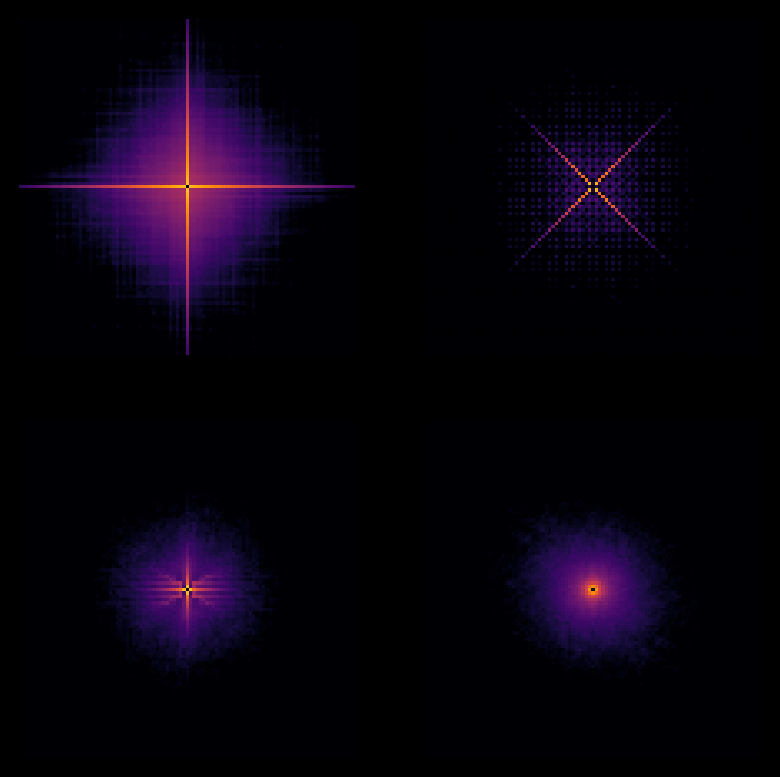

In [92]:
fig = plt.figure(figsize=(5, 5),dpi=192)

for i in range(4):
    gamma = gamma_list[i]
    gamma_center = gamma[:,box_size,:]
    ax = fig.add_subplot(2,2,i+1)
    ax.pcolormesh(np.zeros_like(gamma_center), cmap="gray")
    ax.pcolormesh(np.log(gamma_center).T, cmap = "inferno", vmin=0, vmax=np.log(N_backbone))
    # levels = np.linspace(-12,0,13)
    # ax.contour(qqx*N_backbone,qqy*N_backbone,log_S_q_sm.T, levels=levels, colors='w')
    # ax.set_title(grid,fontsize=18)
    ax.set_xlabel(r'$x$',fontsize=18)
    ax.set_ylabel(r'$y$',fontsize=18)
    # ax.set_xticks([-500,0,500])
    # ax.set_yticks([-500,0,500])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_axis_off()
    ax.set_aspect(1.0)
    fig.patch.set_facecolor('k')

In [82]:
r = np.linspace(-box_size,box_size,2*box_size+1)
r_grid = np.meshgrid(r,r,r)

def plot_isosurface_gamma(gamma, filename):
    # pyvista
    # https://stackoverflow.com/questions/6030098
    grid = pv.StructuredGrid(r_grid[1], r_grid[0], r_grid[2])
    grid["vol"] = gamma.flatten('F')
    mesh_1 = grid.contour([N_backbone/200])
    mesh_2 = grid.contour([N_backbone/2000])

    # Visualization
    pv.set_plot_theme('document')
    pl = pv.Plotter(window_size=[600, 600])
    pl.enable_anti_aliasing('msaa')

    backface_params = dict(color='#36013f',
                                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                                opacity=0.1
                                )
    pl.add_mesh(mesh_1, show_scalar_bar=False, color='#FFC000',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
                opacity=1
                )
    pl.add_mesh(mesh_2, show_scalar_bar=False, color='#C0C0C0',  
                ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
                backface_params=backface_params, 
                smooth_shading=True, 
                opacity=0.00
                )
    
    mesh_cube = pv.Cube(center=[0.0,0.0,0.0], bounds=[-box_size,box_size,-box_size,box_size,-box_size,box_size])
    pl.add_mesh(mesh_cube, opacity=0)
    
    pl.camera_position = 'yz'
    pl.camera.azimuth = -60.0
    pl.camera.elevation = 24.0
    pl.camera.reset_clipping_range()

    pl.add_bounding_box()
    pl.show(screenshot=filename,jupyter_backend="none")

In [83]:
grid_name_list = ["SC","RD","RT","KP"]
for i, grid_name in enumerate(grid_name_list):
    filename = "./img/iso_"+grid_name+".png"
    gamma_gaussian = gaussian_filter(gamma_list[i], sigma=1.25)
    plot_isosurface_gamma(gamma_gaussian, filename)

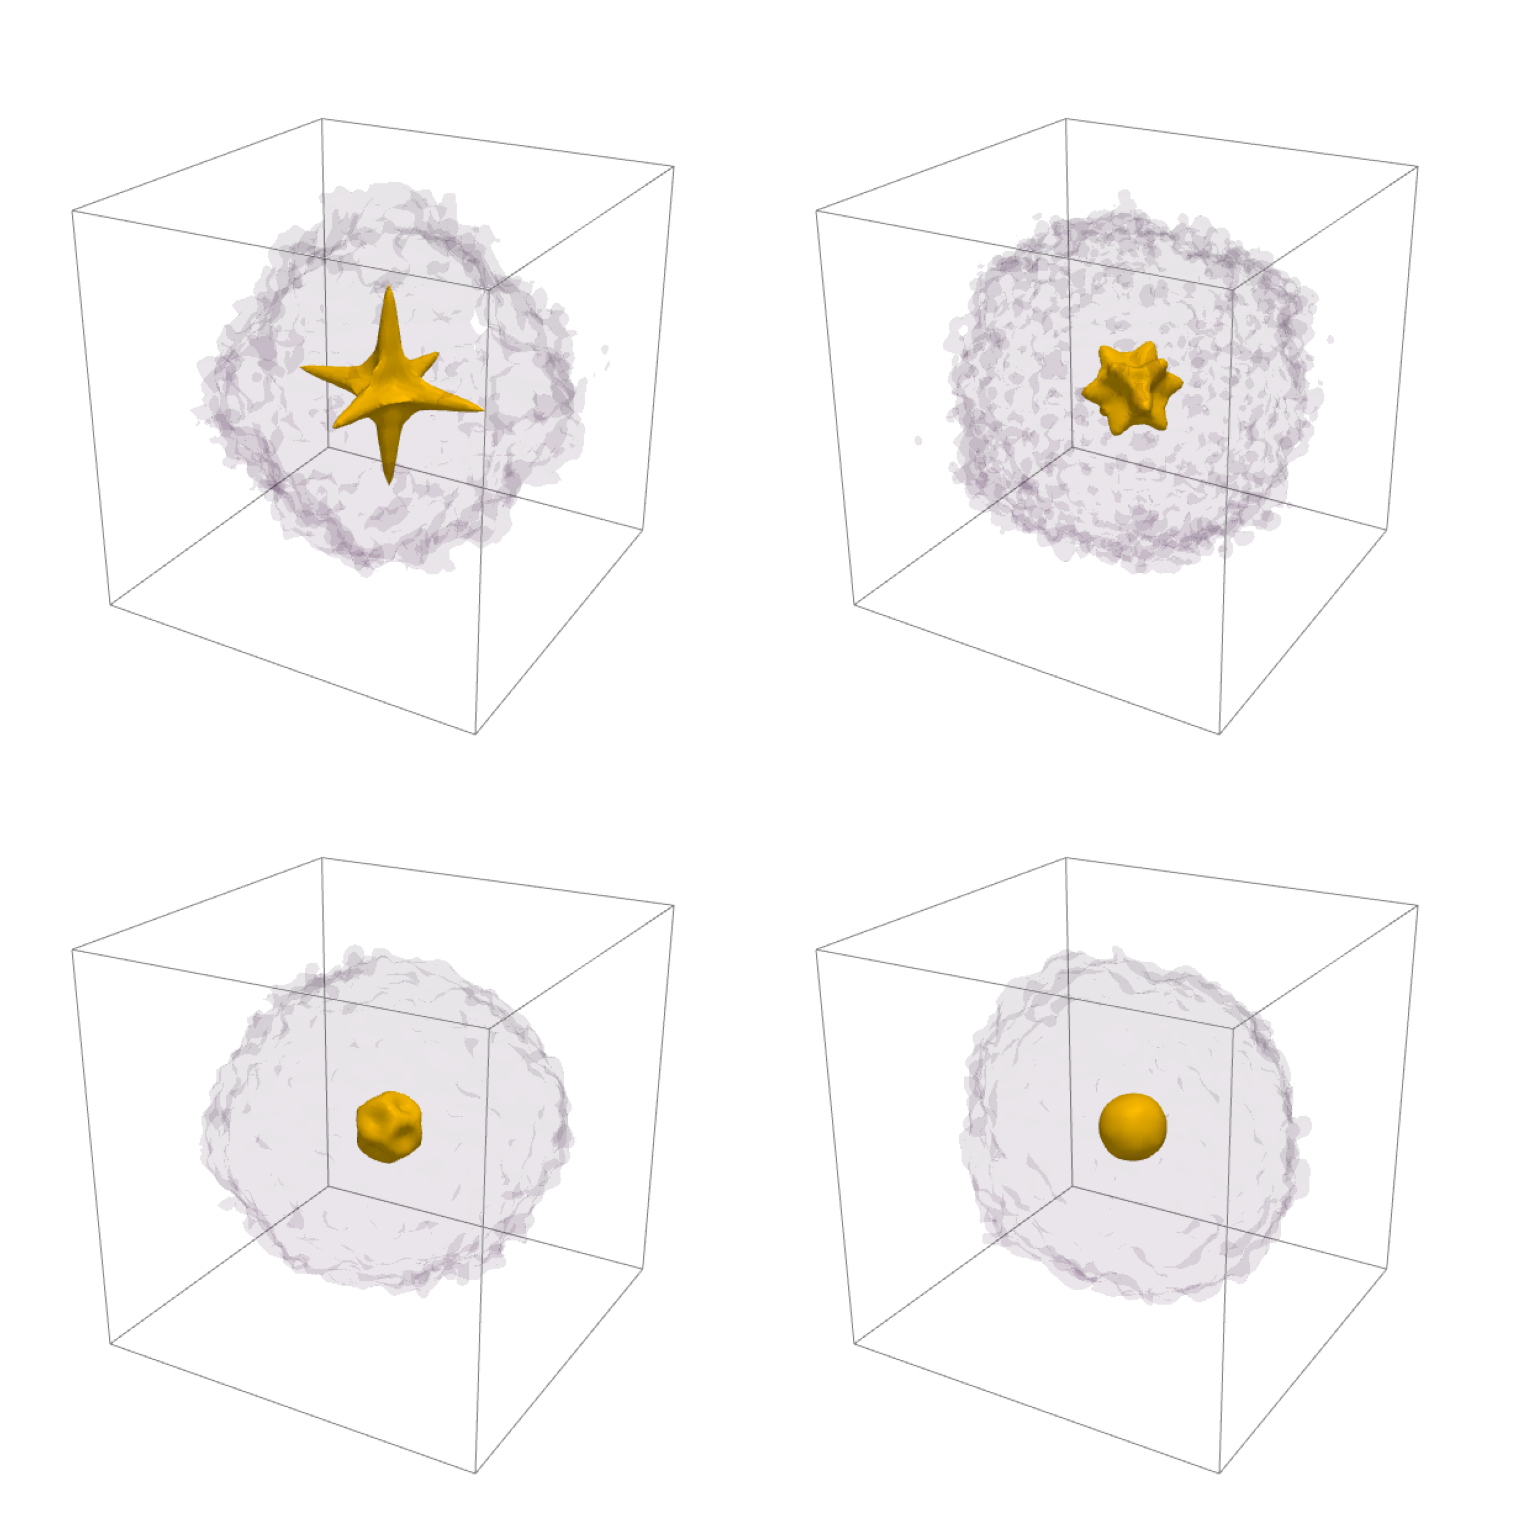

In [89]:
from PIL import Image
fig = plt.figure(figsize=(10,10),dpi=192)
for i, grid_name in enumerate(grid_name_list):
    ax = fig.add_subplot(2,2,i+1)
    # ax.set_title(grid_name, fontsize=20)
    filename = "./img/iso_"+grid_name+".png"
    img = np.asarray(Image.open(filename))
    ax.imshow(img)
    ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()  

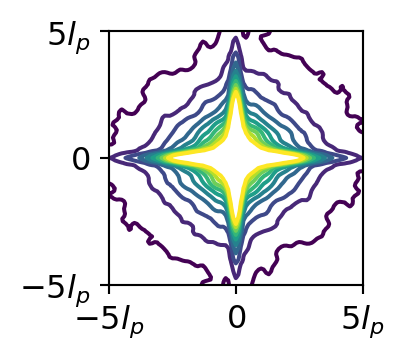

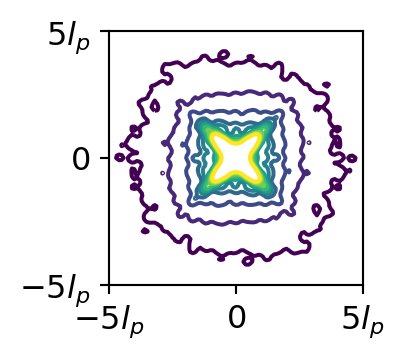

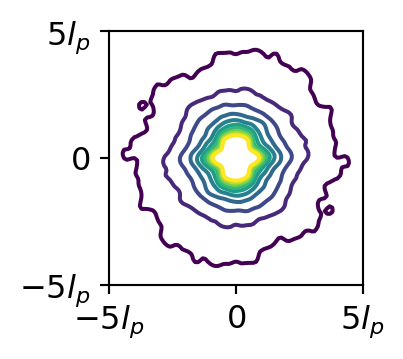

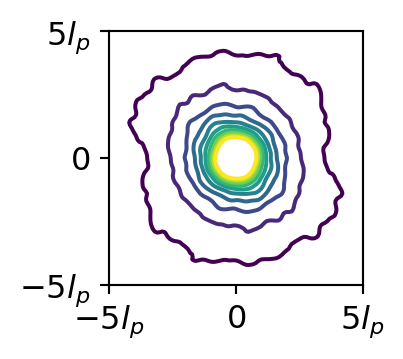

In [124]:
# fig = plt.figure(figsize=(5, 5),dpi=192)

for i in range(4):
    fig = plt.figure(figsize=(3, 3),dpi=192)
    gamma = gamma_list[i]
    gamma_gaussian = gaussian_filter(gamma_list[i], sigma=1.25)
    gamma_center = gamma_gaussian[:,box_size,:]
    ax = fig.add_subplot(1,1,1)
    levels = N_backbone/2000*np.linspace(1,10,10)
    ax.contour(r_grid[0][:,:,0],r_grid[1][:,:,0],gamma_center, levels)
    
    # ax.pcolormesh(np.zeros_like(gamma_center), cmap="gray")
    # ax.pcolormesh(np.log(gamma_center).T, cmap = "gray", vmin=0, vmax=np.log(N_backbone))
    # levels = np.linspace(-12,0,13)
    # ax.contour(qqx*N_backbone,qqy*N_backbone,log_S_q_sm.T, levels=levels, colors='w')
    # ax.set_title(grid,fontsize=18)
    # ax.set_xlabel(r'$x$',fontsize=18)
    # ax.set_ylabel(r'$y$',fontsize=18)
    ax.set_xticks([-50,0,50])
    ax.set_yticks([-50,0,50])
    ax.set_xticklabels([r"$-5l_p$",r"$0$",r"$5l_p$"])
    ax.set_yticklabels([r"$-5l_p$",r"$0$",r"$5l_p$"])
    ax.tick_params(axis='both', which='major', labelsize=12)
    # ax.set_axis_off()
    ax.set_aspect(1.0)
    plt.tight_layout(pad=4)
    # fig.patch.set_facecolor('k')

In [18]:
def plot_CC(Cc, ax, show_axes=1, end=1, axeslabel='off'):
    """
    Plot polymer chain.
    
    Args:
        filename: str
    """
            
    ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
            '-', color='#D00000', linewidth=2, alpha = 0.75)
    # ax.plot(Cc[0,:],Cc[1,:],Cc[2,:], 
    #         'o', markeredgecolor='#800000', markerfacecolor='#D00000')

    # plot chain end
    if end==1:
        ax.plot(Cc[0,0],Cc[1,0],Cc[2,0], 
                    'o', markeredgecolor='#000080', markerfacecolor='#0000D0')
        ax.plot(Cc[0,-1],Cc[1,-1],Cc[2,-1], 
                    'o', markeredgecolor='#008000', markerfacecolor='#00D000')

    #CM = np.mean(Cc_backbone,axis=1)
    CT = np.array([np.max(Cc[0,:])+np.min(Cc[0,:]),
                    np.max(Cc[1,:])+np.min(Cc[1,:]),
                    np.max(Cc[2,:])+np.min(Cc[2,:])])/2
    d_box = np.max([np.max(Cc[0,:])-np.min(Cc[0,:]),
                    np.max(Cc[1,:])-np.min(Cc[1,:]),
                    np.max(Cc[2,:])-np.min(Cc[2,:])])

    if axeslabel=='on':
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        ax.set_zlabel(r'$z$')

    if show_axes==0:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        #ax.axis('off')

    ax.set_xlim([CT[0]-d_box/2, CT[0]+d_box/2])
    ax.set_ylim([CT[1]-d_box/2, CT[1]+d_box/2])
    ax.set_zlim([CT[2]-d_box/2, CT[2]+d_box/2])
    ax.set_box_aspect([1,1,1])

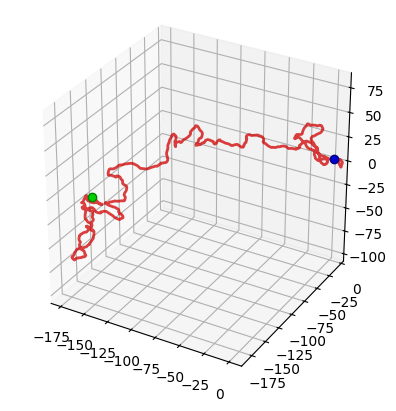

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_CC(Cc, ax, show_axes=1, end=1, axeslabel='off')